In [11]:
from scipy.stats.mstats import gmean
import pandas
import numpy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn
import matplotlib.pyplot as plt


state_list = [
  "Alabama",
  "Alaska",
  "Arizona",
  "Arkansas",
  "California",
  "Colorado",
  "Connecticut",
  "Delaware",
  "District of Columbia",
  "Florida",
  "Georgia",
  "Hawaii",
  "Idaho",
  "Illinois",
  "Indiana",
  "Iowa",
  "Kansas",
  "Kentucky",
  "Louisiana",
  "Maine",
  "Maryland",
  "Massachusetts",
  "Michigan",
  "Minnesota",
  "Mississippi",
  "Missouri",
  "Montana",
  "Nebraska",
  "Nevada",
  "New Hampshire",
  "New Jersey",
  "New Mexico",
  "New York",
  "North Carolina",
  "North Dakota",
  "Ohio",
  "Oklahoma",
  "Oregon",
  "Pennsylvania",
  "Rhode Island",
  "South Carolina",
  "South Dakota",
  "Tennessee",
  "Texas",
  "Utah",
  "Vermont",
  "Virginia",
  "Washington",
  "West Virginia",
  "Wisconsin",
  "Wyoming",
]


data_1 = pandas.read_csv("CAGDP1__ALL_AREAS_2001_2020.csv", encoding="ISO-8859-1")
data_1 = data_1[data_1["Description"] == "Real GDP (thousands of chained 2012 dollars)"]
data_1 = data_1[data_1["GeoName"].isin(state_list)]
data_1 = data_1.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="gdp")
data_1 = data_1.dropna()
data_1 = data_1[data_1["gdp"] != "(NA)"]
data_1["gdp"] = data_1["gdp"].astype("int64")
data_1["year"] = data_1["year"].astype("int")
data_1.head()

,GeoName,year,gdp
0,Alabama,2001,156853184
1,Alaska,2001,40958700
2,Arizona,2001,213166188
3,Arkansas,2001,89789042
4,California,2001,1692324096


In [12]:
data_2 = pandas.read_excel("download.xls", skiprows=range(0, 5), nrows=59)
data_2["GeoName"] = data_2["GeoName"].replace("Alaska *", "Alaska")
data_2 = data_2.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2001, 2020)], var_name="year",
                     value_name="population")
data_2["year"] = data_2["year"].astype("int")
data_2.head()

,GeoName,year,population
0,Alabama,2001,4467634
1,Alaska,2001,633714
2,Arizona,2001,5273477
3,Arkansas,2001,2691571
4,California,2001,34479458


In [13]:
data_3 = pandas.read_csv("SAIRPDImplicitRegionalPriceDeflatorsbystate.csv")
data_3 = data_3.melt(id_vars=["GeoName"], value_vars=[str(i) for i in range(2008, 2020)], var_name="year",
                     value_name="regional_deflator")
data_3["year"] = data_3["year"].astype("int")
data_3.head()


,GeoName,year,regional_deflator
0,Alabama,2008,84.664
1,Alaska,2008,100.200
2,Arizona,2008,96.960
3,Arkansas,2008,83.946
4,California,2008,103.710


In [14]:
data = pandas.merge(data_1, data_2, on=["GeoName", "year"])
data = pandas.merge(data, data_3, on=["GeoName", "year"])
data = data.rename({"GeoName": "state"}, axis=1)
data["gdp_per_capita"] = data["gdp"] / data["population"]
data["gdp_per_capita"] = data["gdp_per_capita"] / data["regional_deflator"]
data_Y0 = data[data["year"] == 2008][["state", "gdp_per_capita"]]
data = data.sort_values(["state", "year"])
data["gdp_per_capita_t-1"] = data.groupby("state")["gdp_per_capita"].shift(1)
data["gdp_per_capita_growth"] = data["gdp_per_capita"] / data["gdp_per_capita_t-1"]
data = data.dropna()
data.head()

,state,year,gdp,population,regional_deflator,gdp_per_capita,gdp_per_capita_t-1,gdp_per_capita_growth
50,Alabama,2009,180707162,4757938,83.419,0.455294,0.467996,0.972858
100,Alabama,2010,184702392,4785514,86.912,0.444083,0.455294,0.975377
150,Alabama,2011,187605835,4799642,89.186,0.438269,0.444083,0.986908
200,Alabama,2012,189245509,4816632,91.156,0.431019,0.438269,0.983459
250,Alabama,2013,191369800,4831586,92.163,0.429761,0.431019,0.997081


In [15]:
data_agg = data.groupby(by="state").agg({"gdp_per_capita_growth": [gmean]}) - 1
data_agg.columns = data_agg.columns.droplevel()
data_agg.head()

,gmean
state,
Alabama,-0.009120
Alaska,-0.013661
Arizona,-0.010520
Arkansas,-0.009435
California,0.005223


In [16]:
data_final = pandas.merge(data_agg, data_Y0, on=["state"])
data_final["ln_gdp_per_capita"] = numpy.log(data_final["gdp_per_capita"])
data_final.head()

,state,gmean,gdp_per_capita,ln_gdp_per_capita
0,Alabama,-0.009120,0.467996,-0.759296
1,Alaska,-0.013661,0.744046,-0.295653
2,Arizona,-0.010520,0.461143,-0.774048
3,Arkansas,-0.009435,0.441497,-0.817584
4,California,0.005223,0.543074,-0.610509


In [17]:
X = sm.add_constant(data_final)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.849
Date:                Fri, 04 Feb 2022   Prob (F-statistic):             0.0979
Time:                        13:43:35   Log-Likelihood:                 183.24
No. Observations:                  50   AIC:                            -362.5
Df Residuals:                      48   BIC:                            -358.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0110      0.003     -4.310      0.000      -0.016      -0.006
ln_gdp_per_capita    -0.0068      0.004     -1.688      0.098      -0.015       0.001
==============================================================================
Omnibus:                        7.953   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.081
Skew:                           0.630   Prob(JB):                       0.0176
Kurtosis:                       4.513   Cond. No.                         6.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

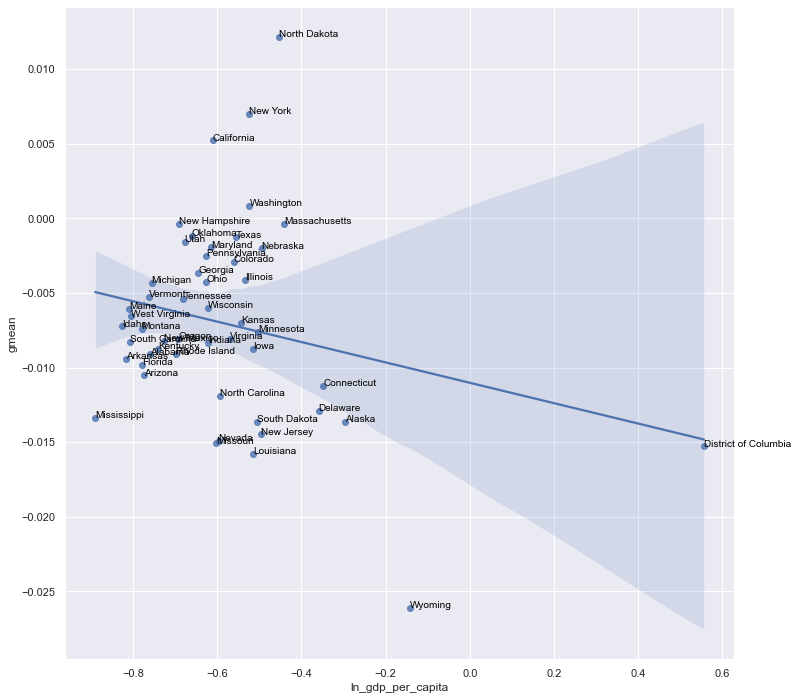

In [18]:
seaborn.set(rc={'figure.figsize':(12, 12)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final)
for line in range(0,data_final.shape[0]):
     plt.text(data_final.ln_gdp_per_capita[line], data_final.gmean[line], data_final.state[line], size='small', color='black')


In [21]:
data_final = data_final[~data_final["state"].isin(["Alaska", "Wyoming", "District of Columbia", "New York"])]
data_final = data_final.reset_index()
X = sm.add_constant(data_final)
mod = smf.ols(formula="gmean ~ ln_gdp_per_capita", data=X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gmean   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4919
Date:                Fri, 04 Feb 2022   Prob (F-statistic):              0.487
Time:                        13:43:58   Log-Likelihood:                 174.99
No. Observations:                  46   AIC:                            -346.0
Df Residuals:                      44   BIC:                            -342.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0037      0.004     -0.897      0.375      -0.012       0.005
ln_gdp_per_capita     0.0045      0.006      0.701      0.487      -0.008       0.017
==============================================================================
Omnibus:                        6.541   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.762
Skew:                           0.604   Prob(JB):                       0.0561
Kurtosis:                       4.244   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

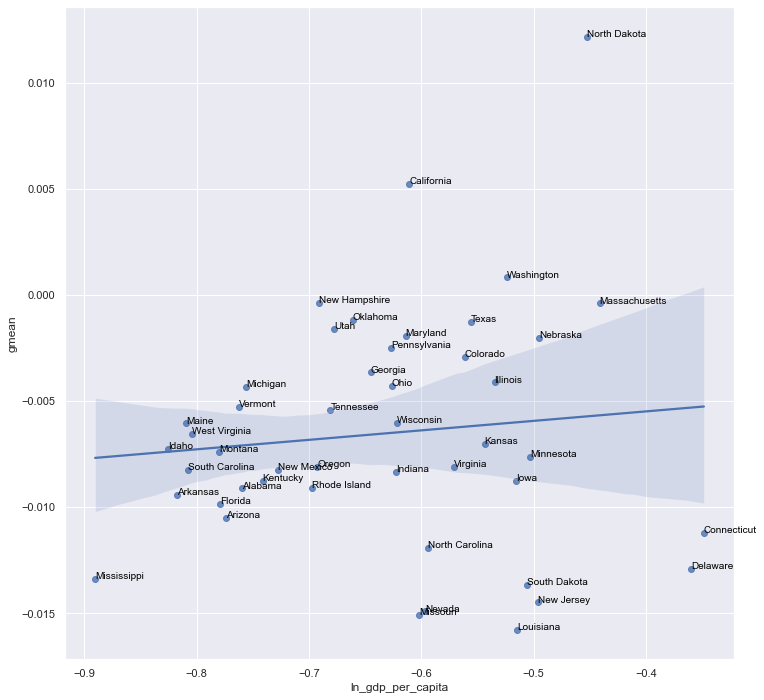

In [20]:
seaborn.set(rc={'figure.figsize':(12, 12)})
seaborn.regplot(x="ln_gdp_per_capita", y="gmean", data=data_final)
for line in range(0,data_final.shape[0]):
     plt.text(data_final.ln_gdp_per_capita[line], data_final.gmean[line], data_final.state[line], size='small', color='black')

https://link.springer.com/article/10.1007/s12197-020-09520-w
